# Geometrical Optics - Tracing Rays and Calculating Amplitude

In [133]:
import finite_diff as fd
import torch
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import matplotlib as mpl
from scipy.integrate import solve_ivp, cumulative_trapezoid
from scipy.special import airy

In [134]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

# Exact and GO solution away from cutoff

### Exact Solution

In [135]:
from scipy.special import airy

def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

x = np.linspace(-8, 0, 1000)
E_ex = Ai(x) # Exact solution is Airy function

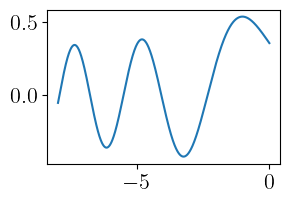

In [136]:
plt.figure(figsize=(3,2))
plt.plot(x, E_ex)
plt.show()

#### Find first peak

In [137]:
from scipy.signal import find_peaks
first_peak_ind = find_peaks(E_ex)[0][0]
x0  = x[first_peak_ind]
phi0 = E_ex[first_peak_ind]

### Tradtional GO Solution using only 1D from ray tracing

In [138]:
from trace_ray import trace_ray, get_t
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle

In [139]:
@torch_func
def D(r: ('vector'), k: ('vector'), omega: ('scalar')):
    x, y, z = r
    return - x - inner_product(k, k)

In [140]:
r0 = np.array([x0, 0, 0])
k0 = np.array([np.sqrt(-x0), 0, 0])
omega0 = 1.0
sol = trace_ray(r0, k0, omega0, tmin=0, tmax=8, D=D, r_min=np.array([x0, 0, 0]))
r = sol.y[:3]
k = sol.y[3:]
t = sol.t

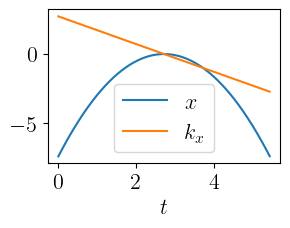

In [141]:
plt.figure(figsize=(3,2))
plt.plot(t, r[0], label=r'$x$')
plt.plot(t, k[0], label=r'$k_x$')
plt.xlabel(r'$t$')
plt.legend()
plt.show()

In [142]:
# def diff(f, x):
#     '''Returns three-point estimate (central difference) of derivative of f with respect to x'''
#     df = np.diff(f)
#     h = np.diff(x[:2])[0]
#     dfdx_l = (-3*f[0] + 4*f[1] - f[2])/(2*h)
#     dfdx_c = (df[1:] + df[:-1])/(2*h)
#     dfdx_r = (f[-3] - 4*f[-2] + 3*f[-1])/(2*h)
#     return np.hstack([dfdx_l, dfdx_c, dfdx_r])

In [143]:
def np_inner_product(a, b):
    if len(a.shape) == 2:
        return np.matmul(a.T, b).diagonal()
    else:
        return np.dot(a, b)

In [144]:
J = fd.grad(r[0], t)
phi = phi0*np.sqrt(J[0]/J[J>0])

gradt_r = np.vstack([fd.grad(r[0], t), fd.grad(r[1], t), fd.grad(r[2], t)])
theta0 = 0
theta = theta0 + cumulative_trapezoid(np_inner_product(k, gradt_r), t, initial=0)[J>0]

E_GO = phi*np.cos(theta)

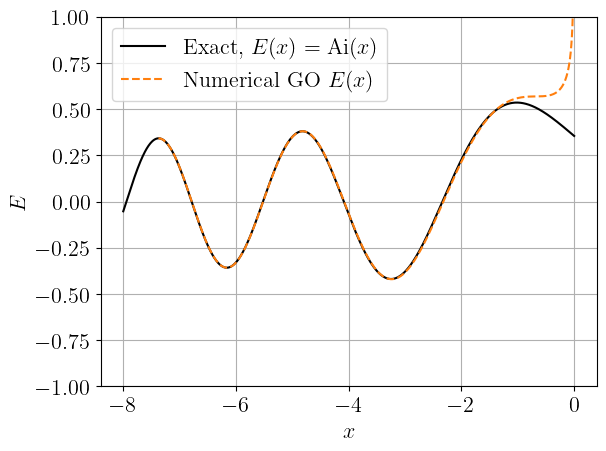

In [146]:
plt.plot(x, E_ex, 'k-', label='Exact, $E(x) = \mathrm{Ai}(x)$')
plt.plot(r[0][J>0], E_GO, '--', color='tab:orange', label='Numerical GO $E(x)$')
plt.ylim(-1, 1)
plt.xlabel('$x$')
plt.ylabel('$E$')
plt.grid()
plt.legend()
plt.show()

**Comments:**

- As expected, we clearly see the divergence of the electric field as $x \to 0$. This is due to the caustic at $x=0$, where $J = \partial_\tau r \to 0$ (or put another way, $\partial^2_x \theta \to \infty$).
- In general, the GO solution is not even valid away from the caustic, since the caustic gives rise to a reflected wave. We should in principle add the contribution from both the incoming and reflected wave. However, in this specific case, we have symmetry in $(x, k_x)$-space since the wave is directly incoming on the caustic. Therefore, when we match the amplitude and phase of the incoming wave with the exact Airy function solution, we actually do end up with the correct result away from the caustic.

### GO Solution using 3D Manifold

... This is a work in progress.

In 3D we should launch a family of rays satisfying some 2D boundary conditions.

In [147]:
n2, n3 = 10, 20

y = np.linspace(0, 1, n2)
z = np.linspace(0, 10, n3)
Y, Z = np.meshgrid(y, z, indexing='ij')

In [149]:
nt = 1000
rs = np.zeros((n2, n3, 3, nt))
ks = np.zeros((n2, n3, 3, nt))
omega0 = 1.0
# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt
for i, y0 in enumerate(y):
    for j, z0 in enumerate(z):
        tau_ind = (i, j)
        sol = trace_ray(r0 = np.array([x0, y0, z0]), k0=np.array([np.sqrt(-x0), 0, 0]), omega0=omega0, tmin=0, tmax=8, D=D, r_min=np.array([x0, 0, 0]), tsteps=nt)
        sol_nt = len(sol.t)
        rs[i, j, :, :sol_nt] = sol.y[:3]
        ks[i, j, :, :sol_nt] = sol.y[3:]
        min_nt = np.min((sol_nt, min_nt))
nt = min_nt
rs = rs[:, :, :, :min_nt]
ks = ks[:, :, :, :min_nt]

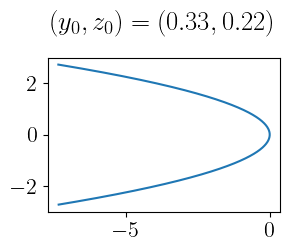

In [151]:
i, j = (3, 2)
plt.figure(figsize=(3,2))
plt.plot(rs[0, 0, 0, ], ks[0, 0, 0, ])
plt.title(r'$(y_0, z_0) = (' + str(round(y[i], 2)) + ', ' + str(round(y[j], 2)) + ')$')
plt.show()

In [154]:
J = fd.grad(r[0], t)
phi = phi0*np.sqrt(J[0]/J[J>0])

gradt_r = np.vstack([fd.grad(r[0], t), fd.grad(r[1], t), fd.grad(r[2], t)])
theta0 = 0
theta = theta0 + cumulative_trapezoid(np_inner_product(k, gradt_r), t, initial=0)[J>0]

E_GO = phi*np.cos(theta)